In [7]:
"""This is video reader with all operations inside fnctions, so they can be called on 
    each frame out of a set of frames, and each video out of a set of videos
    """

'This is video reader with all operations inside fnctions, so they can be called on \n    each frame out of a set of frames, and each video out of a set of videos\n    '

In [8]:
"""Imports"""
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from skimage import measure
from skimage.filters import threshold_yen, threshold_isodata
from operator import attrgetter
import numpy as np
import math
from itertools import chain
from scipy import ndimage 
#import antigravity

In [9]:
"""Functions"""
# read in a file, save the video sequence
def full_avi(filename):
    Vid = skvideo.io.vread(filename)

    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(Vid[0]) # first fame of video
    ax[1].imshow(Vid[-1]) #last frame of video

    print("Video shape is: ", Vid.shape)
    print("Video length is: ", len(Vid))
    
    return Vid

# take a read video; makeit a 2D matrix
def greens(framelist):
    green = framelist[:, :, :, 2]
    #print("This is the green channel of the image")
    #print("The slice shape is: ", green.shape)
    #plt.imshow(green[1], cmap='Greys_r')
    return green


# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, indes):
    # returns a new list, different from the orginal
    fll = len(framelist)
    f_indices = []
    f_ap = f_indices.append
    threshed_images = []
    t_ap = threshed_images.append
    m_lab = measure.label
    m_rop = measure.regionprops
    
    sides = {"bm":[], "b":[], "t":[], "ucf":[]}
    classes = {"bm":[], "br":[], "bl":[], "tr":[], "tl":[], "ucf":[], "newt":[]}
    transitions = {"->bm" :[], "->br":[], "->bl":[], "->tr":[], "->tl":[]}
    
    transition_threshold = 10
    broken = 0
    broken_count = 0
    area_threshold = 1800   # must have enough particles
    convex_thresholds = (2000, 2680)   # convex hull area (> 2500 filtered)  # particles must be in parallelogram
    minor_thresholds = (38, 48) # minor_axis length (< filterd) # particles must be in parallelogram
    major_thresholds = (61, 75)
    last_class = ''
    last_whole = 0
    
    for i in range(fll):
       # print("new_frame")
        frame = framelist[i]
        thresh_img = frame > threshold_yen(frame) # binary image
        img_labelled = m_lab(thresh_img) # contains connected regions
        properties_list = m_rop(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = max(properties_list, key = attrgetter('area'))
        """ for k in range(len(properties_list)):
            if areas[k] > biggest_area:
                biggest_r = properties_list[k]
            else:
                pass"""

        #----------------------filter------------------------- can use actual filter
        test = (biggest_r.filled_area > area_threshold and   # must have enough particles
            biggest_r.minor_axis_length > minor_thresholds[0] # minor_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.minor_axis_length < minor_thresholds[1]  # minor_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.convex_area > convex_thresholds[0]  # convex hull area (> 2500 filtered)  # particles must be in parallelogram
            and biggest_r.convex_area < convex_thresholds[1]  # convex hull area (> 2500 filtered)  # particles must be in parallelogram
            and biggest_r.major_axis_length > major_thresholds[0]  # major_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.major_axis_length < major_thresholds[1])  # major_axis length (< filterd) # particles must be in parallelogram

        if test: # keep frames that have enough paricles, and are not transitions
            f_ap(i) # image's index 
            i_threshed = frame > threshold_isodata(frame)
            img2_labelled = m_lab(i_threshed)
            properties2_list = m_rop(img2_labelled)
            biggest_r2 = max(properties2_list, key = attrgetter('area'))
            t_ap((img_labelled, img2_labelled))
            #-----------------------------classify pt 1---------------------------------------
            coprod = coord_prod(thresh_img, i_threshed)
            side = sideify(biggest_r2)
            clas = classify(side, -coprod)
            sides[side].append((frame, tf - indes[i]))
            classes[clas].append((frame, tf - indes[i]))
            if broken_count >= transition_threshold and side != 'ucf': #if previous n frames were broken, and a transition between identifiableclasses ocurred
                transitions["->" + clas].append((last_whole, i))
            broken = 0 #reset marker to not broken
            broken_count = 0
            last_class = clas
            last_whole = i
        else:
            broken = 1 #set marker to broken
            broken_count += 1
            
    filtrate = framelist[f_indices]
    return [[(filtrate[i], threshed_images[i], indes[i]) for i in range(len(filtrate))], sides, classes, transitions]



        
# take largest isodata image region, and return aclassification
def sideify(idir):
    iner = idir.inertia_tensor[0, 0] + idir.inertia_tensor[1, 1]
    maal = idir.major_axis_length
    mial = idir.minor_axis_length
    sol = idir.solidity 
    ecc = idir.eccentricity
    cva = idir.convex_area
    if sol <= 0.725 or (iner> 405 and mial > 43.5):
        return "bm"
    elif ecc > 0.8 or maal > 65: # or (mial < 41 and maal > 65): # it's on top
        return "t"
    elif ecc < 0.75 or maal < 64.5: #or mial > 42  #and cva > 2200 and iner < 325: #or (maal < 64 and iner < 360): # it's on bottom
        return "b"
    else:
        return "ucf"

def classify(side, coprod):
    if side == "t":
        if coprod > 0:
            return "tl"
        else:
            return "tr"
    elif side == "b": 
        if coprod > 0:
            return "br"
        else:
            return "bl"
    elif side == "bm":
        return "bm"
    elif side == "ucf":
        return "ucf"
    else:
        return "newt"


def coord_prod(thresh_y, thresh_i):
    m_rop = measure.regionprops
    for i in range(0, 1):#len(fl):
        full = largest_region_extractor(measure.label(thresh_y))
        four = largest_region_extractor(measure.label(thresh_i))
        full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
        one_and_some = full^four
        one = largest_region_extractor(measure.label(one_and_some))
        
          
        #Begin finding substitue for major and minor axes herre
        # use min and maax x and  values to find the geometric center
        # or use those to substitue for eigenvectors 
        rotated_one = ndimage.rotate(one, math.degrees(-full_or), reshape = False)
        rotated_full = ndimage.rotate(full, math.degrees(-full_or), reshape = False)
        geo_cent = m_rop(rotated_full.astype(int), coordinates = 'rc')[0].bbox
        #print(geo_cent)
        ave = np.average
        cent_x = ave([geo_cent[1], geo_cent[3]]) 
        cent_y = ave([geo_cent[0], geo_cent[2]])
        #print(cent_x, cent_y)
        
        raw_coords = (m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords).T
        ys = raw_coords[0]
        xs = raw_coords[1]
        x = xs - cent_x
        y = ys - cent_y      
        
        one_com = m_rop(rotated_one.astype(int))[0].centroid
        
        rel_com_one = (one_com[1] - cent_x, one_com[0] - cent_y)
        product = np.prod(rel_com_one)
        return product
        
def rotate_point(point, angle):
    x0 = point[0]
    y0 = point[1]
    x1 = x0*np.cos(angle) - y0*np.sin(angle)
    y1 = x0*np.sin(angle) + y0*np.cos(angle)
    return (x1, y1)
 
def region_selector(labeled_image, label):
    #print(label)
    x = labeled_image == label
    #plt.imshow(x)
    return x

# make a function that takes a set of labeled regions, and then  returns a boolean array containing only the largest
def largest_region_extractor(labeled_regions_set):
    props_lists = measure.regionprops(labeled_regions_set)
    #print(len(labeled_regions_set), len(props_lists))
    biggest_r_p = props_lists[0]
    biggest_r_label = props_lists[0].label
    for i in range(0, len(props_lists)):
        pli = props_lists[i]
        if pli.area > biggest_r_p.area:
            biggest_r_p = pli
            biggest_r_label = pli.label
        else:
            pass
    return region_selector(labeled_regions_set, biggest_r_label)    
#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


Video shape is:  (16123, 256, 256, 3)
Video length is:  16123


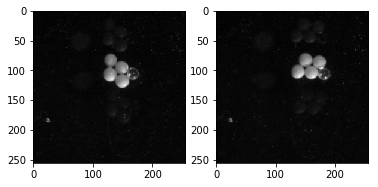

In [10]:
"""Pipeline for videos:"""
# initialize frame list
#filename2 = "./tchakamau/New_setup/45701_10Vpp_18_tester.avi"
filename = "./tchakamau/New_setup/45681_10Vpp_25.avi"
frame_vid = full_avi(filename) # making videos ino a frame list
#frame_vid_2 = full_avi(filename2) # making videos ino a frame list
#-----------------------------------------------------------------------



In [11]:
tf = 26894 
tf2 = 24703
l = list(chain(range(300, 400, 10), 
                          range(2000, 2200, 10), range(4000, 4100, 10), 
               range(6500,6600, 10),
                          range(10000, 10200, 10), range(14000, 14100, 10)))
g = list(range(24703, 6475, -230))
l2 = [tf2 - x for x in g]
l.sort()
l2.sort()
h = l+ l2
print(len(l), len(l2), len(h))

80 80 160


(80, 256, 256, 3)


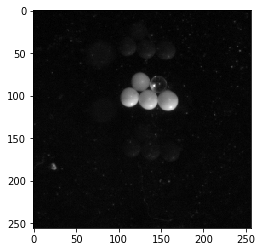

In [12]:
framelist = frame_vid[l]#np.concatenate((frame_vid[l], frame_vid_2[l2]))# will be replaced by full video
plt.imshow(framelist[-1])
print(framelist.shape)

In [13]:
"""Pipeline for lists of frames"""
"""And test thereof (using isinar)"""
def piped(framelist, h):
    # key variable to be passed into the function is framelist
    green_frames = greens(framelist) # making a green slice
    filtered_frames = total_threshold_filter(green_frames, h)
    return filtered_frames

def isinar(a, als):
    #print(a)
    y = False
    for ele in als:
        #print(ele)
        y = np.array_equal(ele, a)
        if y:
            return y
        else: 
            continue
    return y

org = piped(framelist, h)
twf = org[0]
sids = org[1]
cls = org[2]
tran = org[3]
print("unfiltered ", len(framelist))
print("filtered ", len(twf))
print("length of sides ", len([x for y in sids.values() for x in y]))
print("length of classes ", len([x for y in cls.values() for x in y]))
filts = [j[ :, :, 2] for j in framelist if not isinar(j[:, :, 2], [k[0] for k in twf] )] #jnot in [k[0] for k in twf]]
print("length of filtered out slides ", len(filts))

print("length of side classifs ", [[x, len(sids[x])] for x in sids])
print("lengths of each classes classif ", [[x, len(cls[x])] for x in cls])

print("lengths of each transition classif ", [[x, len(tran[x])] for x in tran])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


unfiltered  80
filtered  57
length of sides  57
length of classes  57
length of filtered out slides  23
length of side classifs  [['bm', 10], ['b', 20], ['t', 27], ['ucf', 0]]
lengths of each classes classif  [['bm', 10], ['br', 18], ['bl', 2], ['tr', 17], ['tl', 10], ['ucf', 0], ['newt', 0]]
lengths of each transition classif  [['->bm', 0], ['->br', 1], ['->bl', 0], ['->tr', 0], ['->tl', 0]]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


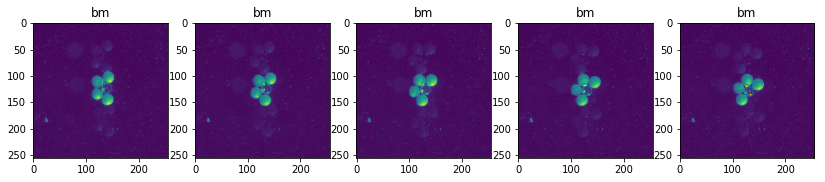

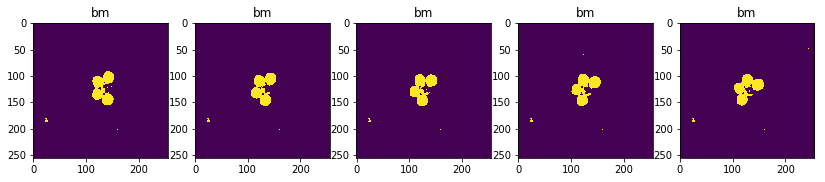

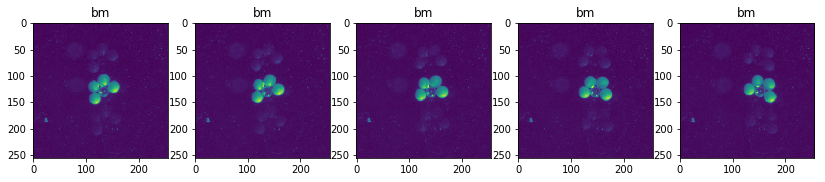

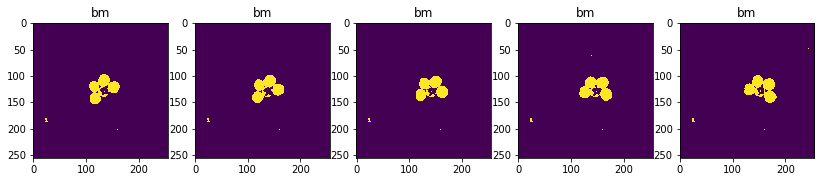

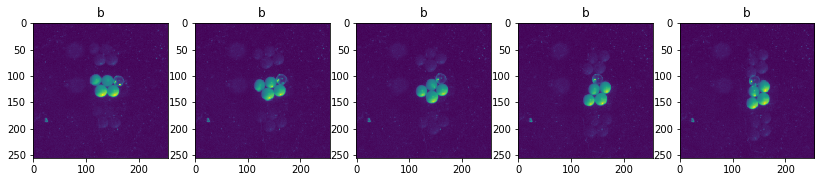

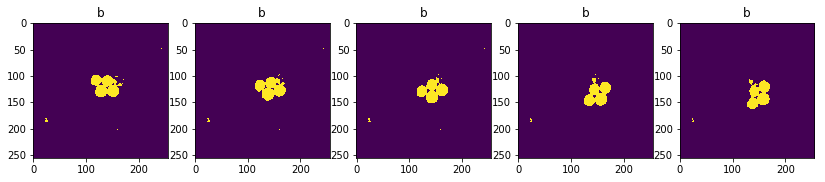

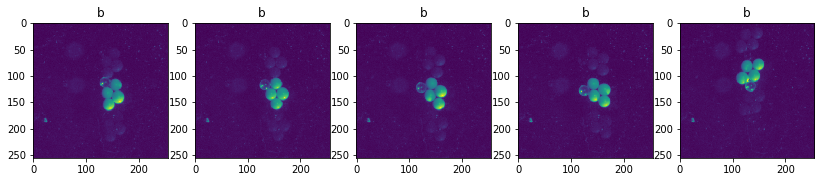

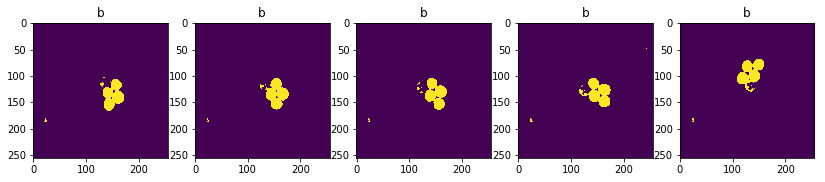

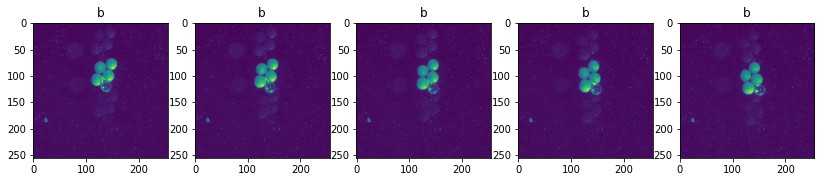

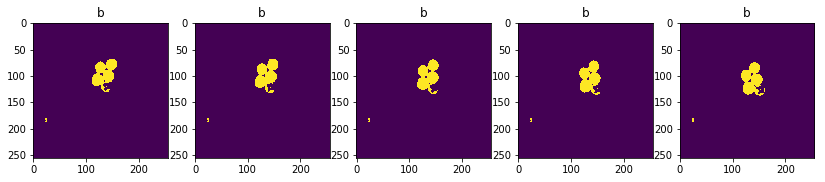

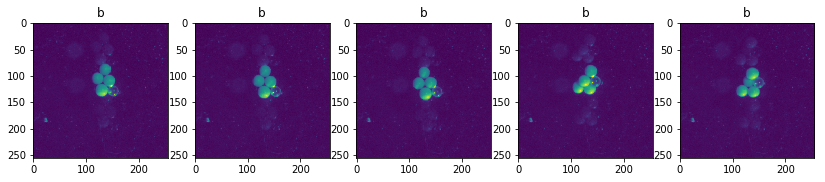

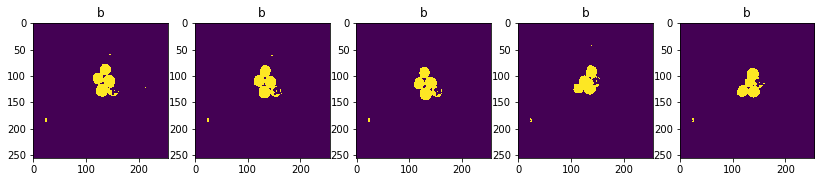

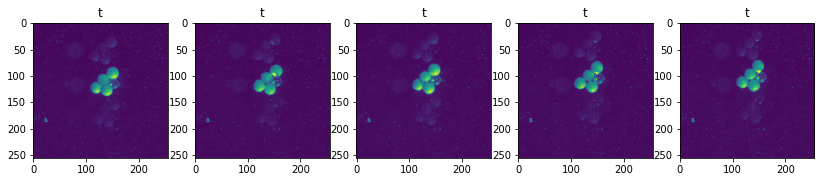

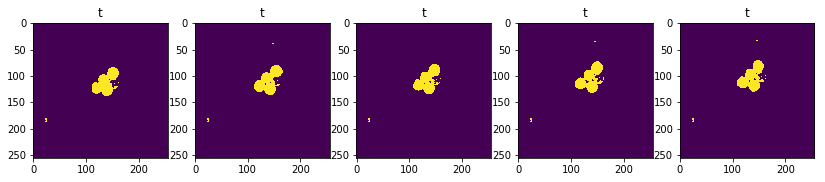

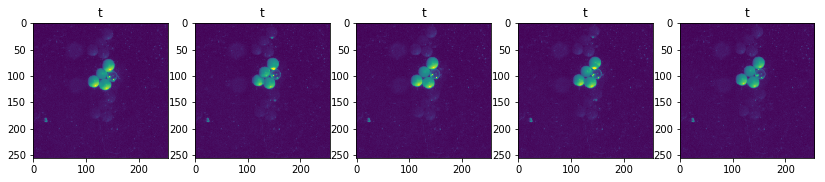

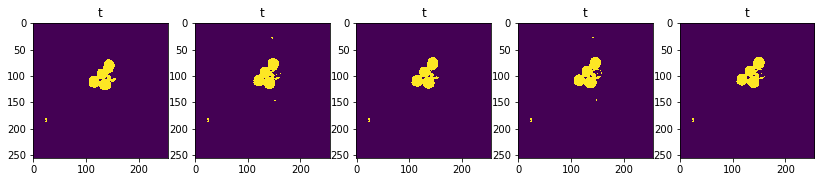

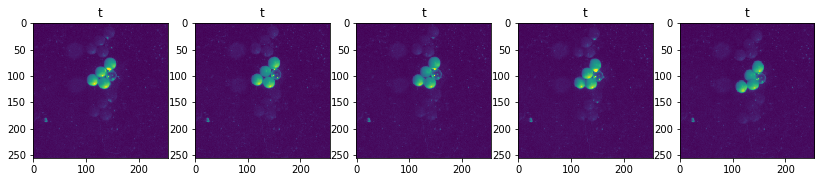

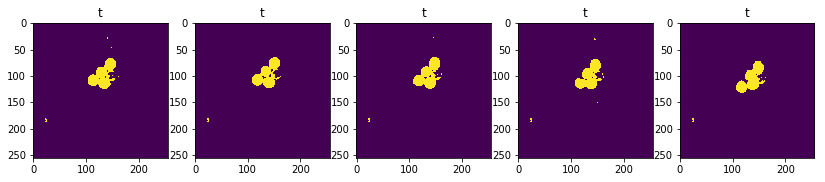

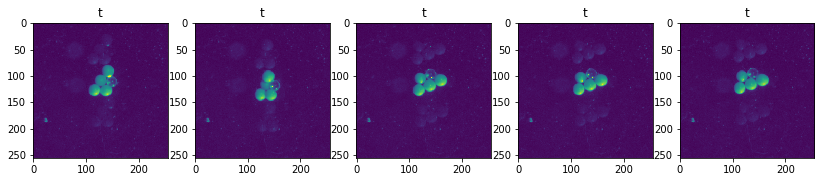

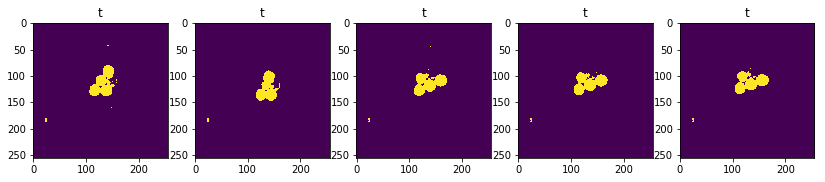

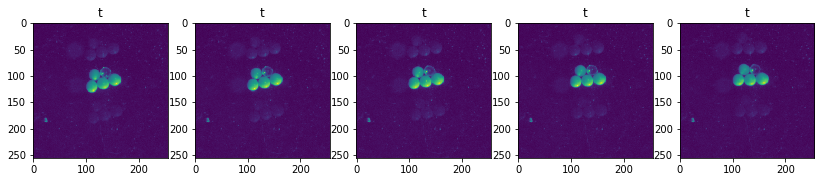

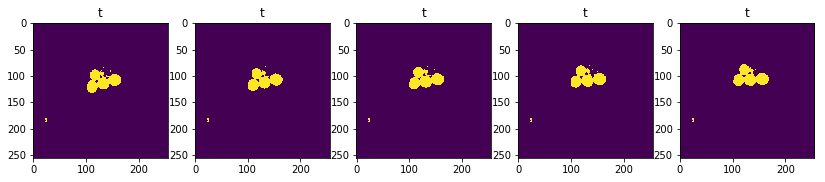

In [14]:
"""Visualizethe classifiedobjects"""
for key in sids.keys():
    vals = sids[key]
    frames = [val[0] for val in vals]
    c = 5
    r = len(vals)// c
    for j in range(r):
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame)
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame > threshold_isodata(frame))
    
    

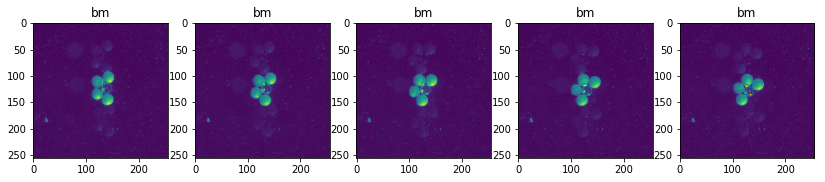

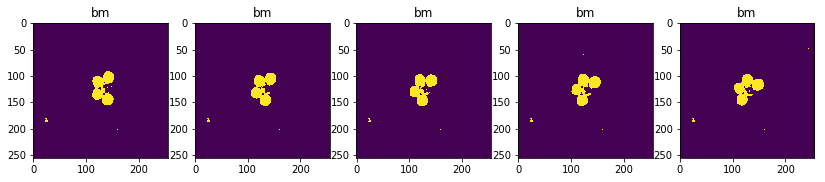

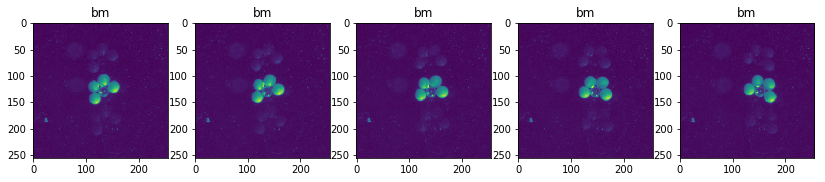

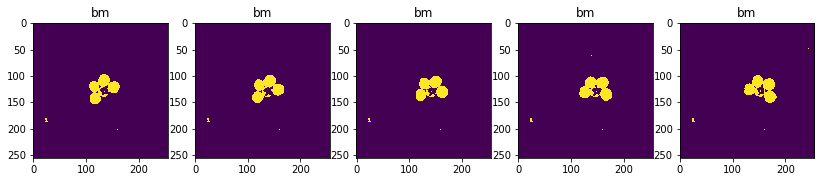

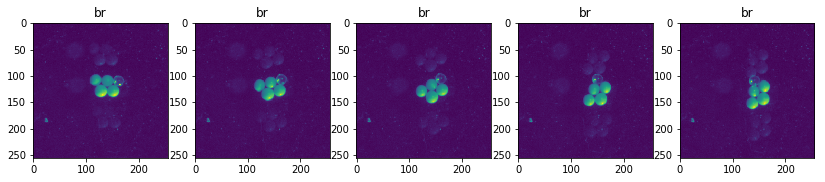

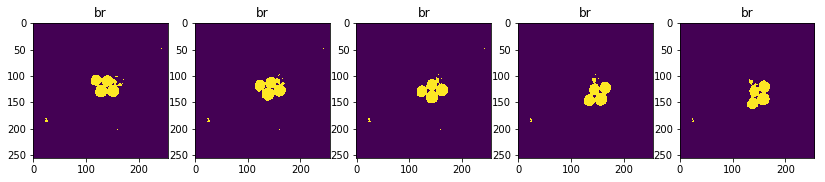

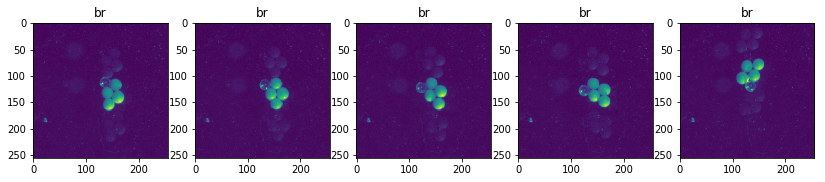

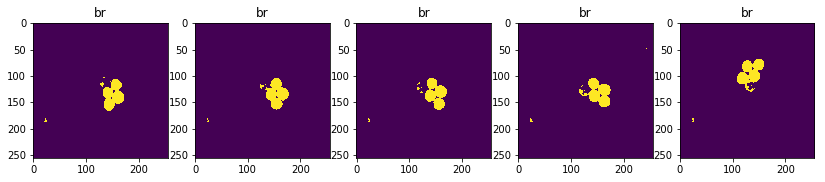

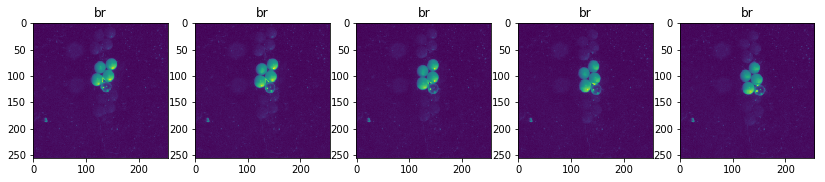

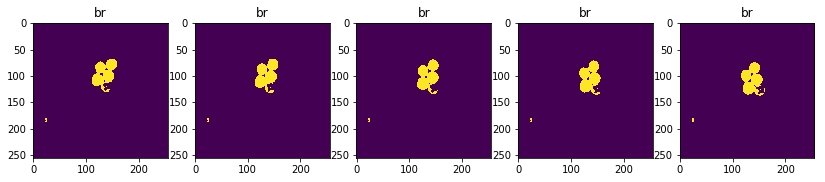

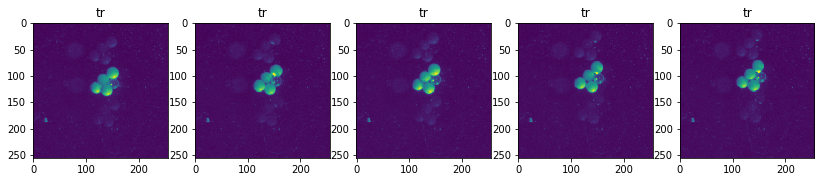

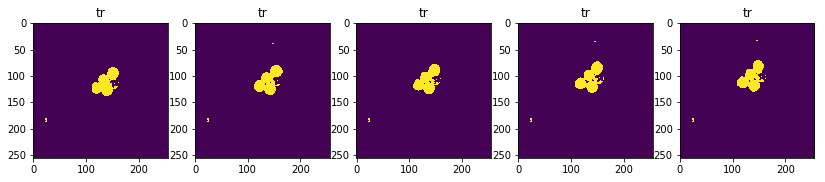

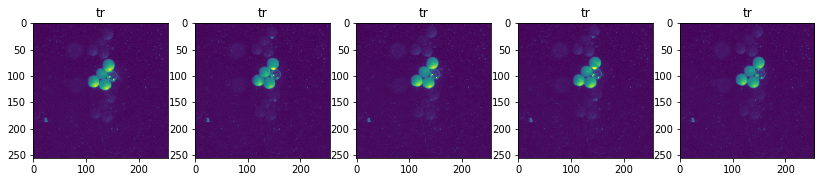

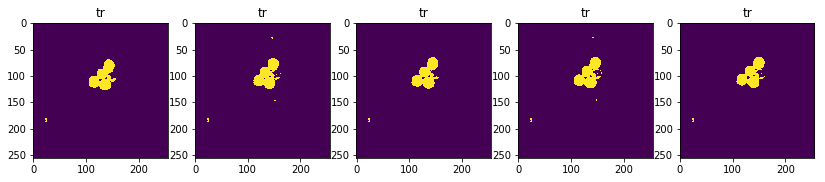

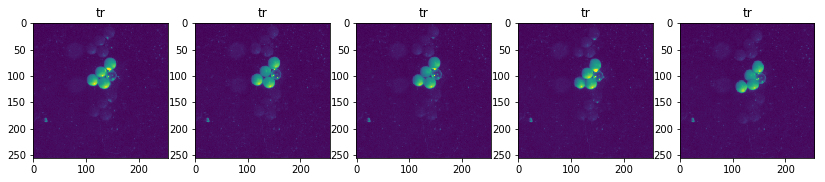

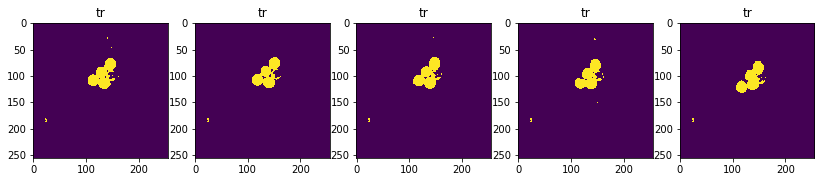

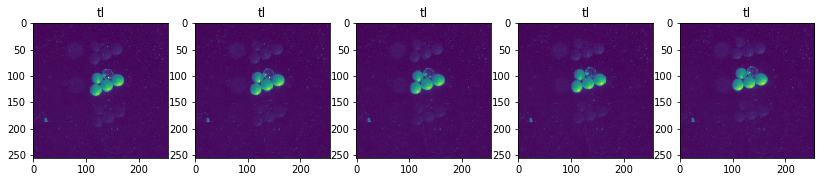

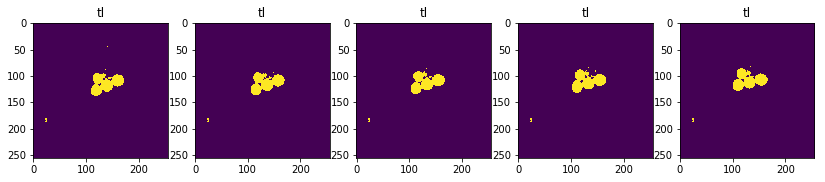

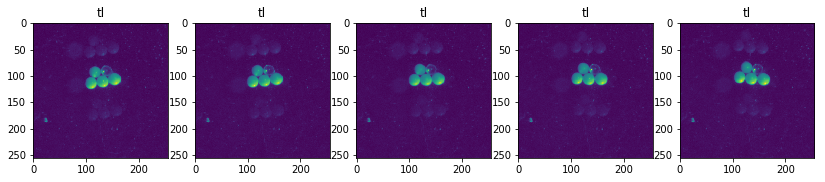

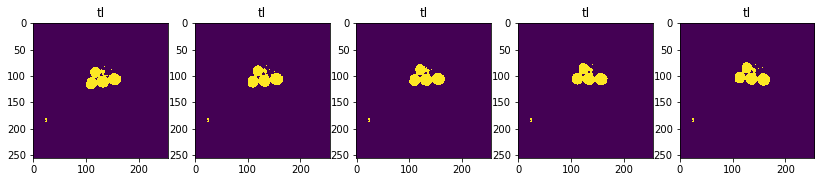

In [15]:
"""Visualizethe classifiedobjects"""
for key in cls.keys():
    vals = cls[key]
    frames = [val[0] for val in vals]
    c = 5
    r = len(vals)// c
    for j in range(r):
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame)
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame > threshold_isodata(frame))

In [23]:
"""Applying to full vid"""
frams = frame_vid
org = piped(frams, range(len(frame_vid)))
twf = org[0]
sids = org[1]
cls = org[2]
tran = org[3]
filtered_len = len(twf)



In [24]:
trans_len = len([y for x in tran.values() for y in x])
#print("t_thresh : ", transition_threshold)
print("unfiltered ", len(frams))
print("filtered", filtered_len)
#filts = [j[ :, :, 2] for j in framelist if not isinar(j[:, :, 2], [k[0] for k in twf] )] #jnot in [k[0] for k in twf]]
#print("length of filtered out slides ", len(filts))
skeys = list(sids.keys())
print ('skeys', skeys)
ckeys = list(cls.keys())
print ('ckeys', ckeys)
tkeys = list(tran.keys())
print ('tkeys', tkeys)
slcs = [len(sids[x]) for x in skeys]
clcs = [len(cls[x]) for x in ckeys]
trans = [len(tran[x]) for x in tkeys]
ucf = len(sids["ucf"])
newtucf = len(cls["newt"]) + ucf
#print(slcs, clcs, trans)

print("number transitions : ", trans_len)
print("\nlengths of broad classifications (from side classificaton)")
[print(skeys[i], slcs[i], ': %.f%%' %(slcs[i] *100/ filtered_len)) for i in range(len(skeys))]
print("\nlengths of narrow classifications (from classif classification)")
[print(ckeys[i], clcs[i], ": %.f%%" %(clcs[i] *100/ filtered_len)) for i in range(len(ckeys))]
print("\nlengths of transition sections (from transition count)")
[print(tkeys[i], trans[i], ": %.f%%" %(trans[i] *100/ trans_len)) for i in range(len(tkeys))]

unfiltered  16123
filtered 12491
skeys ['bm', 'b', 't', 'ucf']
ckeys ['bm', 'br', 'bl', 'tr', 'tl', 'ucf', 'newt']
tkeys ['->bm', '->br', '->bl', '->tr', '->tl']
number transitions :  33

lengths of broad classifications (from side classificaton)
bm 2959 : 24%
b 4791 : 38%
t 4709 : 38%
ucf 32 : 0%

lengths of narrow classifications (from classif classification)
bm 2959 : 24%
br 4454 : 36%
bl 337 : 3%
tr 784 : 6%
tl 3925 : 31%
ucf 32 : 0%
newt 0 : 0%

lengths of transition sections (from transition count)
->bm 5 : 15%
->br 9 : 27%
->bl 5 : 15%
->tr 4 : 12%
->tl 10 : 30%


[None, None, None, None, None]

Video shape is:  (78187, 256, 256, 3)
Video length is:  78187


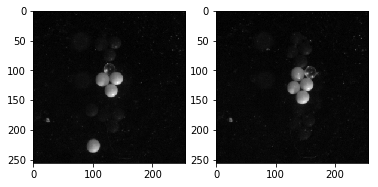

In [25]:
filename = "./tchakamau/New_setup/45681_10Vpp_26.avi"
frame_vid = full_avi(filename) # making videos ino a frame list

In [26]:
"""Applying to full vid"""
frams = frame_vid
org = piped(frams, range(len(frame_vid)))
twf = org[0]
sids = org[1]
cls = org[2]
tran = org[3]
filtered_len = len(twf)



In [27]:
trans_len = len([y for x in tran.values() for y in x])
#print("t_thresh : ", transition_threshold)
print("unfiltered ", len(frams))
print("filtered", filtered_len)
#filts = [j[ :, :, 2] for j in framelist if not isinar(j[:, :, 2], [k[0] for k in twf] )] #jnot in [k[0] for k in twf]]
#print("length of filtered out slides ", len(filts))
skeys = list(sids.keys())
print ('skeys', skeys)
ckeys = list(cls.keys())
print ('ckeys', ckeys)
tkeys = list(tran.keys())
print ('tkeys', tkeys)
slcs = [len(sids[x]) for x in skeys]
clcs = [len(cls[x]) for x in ckeys]
trans = [len(tran[x]) for x in tkeys]
ucf = len(sids["ucf"])
newtucf = len(cls["newt"]) + ucf
#print(slcs, clcs, trans)

print("number transitions : ", trans_len)
print("\nlengths of broad classifications (from side classificaton)")
[print(skeys[i], slcs[i], ': %.f%%' %(slcs[i] *100/ filtered_len)) for i in range(len(skeys))]
print("\nlengths of narrow classifications (from classif classification)")
[print(ckeys[i], clcs[i], ": %.f%%" %(clcs[i] *100/ filtered_len)) for i in range(len(ckeys))]
print("\nlengths of transition sections (from transition count)")
[print(tkeys[i], trans[i], ": %.f%%" %(trans[i] *100/ trans_len)) for i in range(len(tkeys))]

unfiltered  78187
filtered 42101
skeys ['bm', 'b', 't', 'ucf']
ckeys ['bm', 'br', 'bl', 'tr', 'tl', 'ucf', 'newt']
tkeys ['->bm', '->br', '->bl', '->tr', '->tl']
number transitions :  377

lengths of broad classifications (from side classificaton)
bm 8972 : 21%
b 10591 : 25%
t 22154 : 53%
ucf 384 : 1%

lengths of narrow classifications (from classif classification)
bm 8972 : 21%
br 6143 : 15%
bl 4448 : 11%
tr 15918 : 38%
tl 6236 : 15%
ucf 384 : 1%
newt 0 : 0%

lengths of transition sections (from transition count)
->bm 85 : 23%
->br 84 : 22%
->bl 62 : 16%
->tr 72 : 19%
->tl 74 : 20%


[None, None, None, None, None]

Video shape is:  (18053, 256, 256, 3)
Video length is:  18053


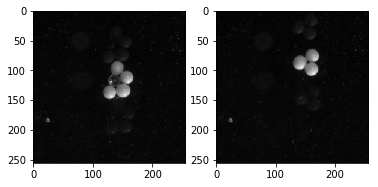

In [67]:
filename = "./tchakamau/New_setup/45681_10Vpp_24.avi"
frame_vid = full_avi(filename) # making videos ino a frame list

In [68]:
"""Applying to full vid"""
frams = frame_vid
org = piped(frams, range(len(frame_vid)))
twf = org[0]
sids = org[1]
cls = org[2]
tran = org[3]
filtered_len = len(twf)



In [75]:
trans_len = len([y for x in tran.values() for y in x])
print([y for x in tran.values() for y in x])
#print("t_thresh : ", transition_threshold)
print("unfiltered ", len(frams))
print("filtered", filtered_len)
#filts = [j[ :, :, 2] for j in framelist if not isinar(j[:, :, 2], [k[0] for k in twf] )] #jnot in [k[0] for k in twf]]
#print("length of filtered out slides ", len(filts))
skeys = list(sids.keys())
print ('skeys', skeys)
ckeys = list(cls.keys())
print ('ckeys', ckeys)
tkeys = list(tran.keys())
print ('tkeys', tkeys)
slcs = [len(sids[x]) for x in skeys]
clcs = [len(cls[x]) for x in ckeys]
trans = [len(tran[x]) for x in tkeys]
ucf = len(sids["ucf"])
newtucf = len(cls["newt"]) + ucf
#print(slcs, clcs, trans)

print("number transitions : ", trans_len)
print("\nlengths of broad classifications (from side classificaton)")
[print(skeys[i], slcs[i], ': %.f%%' %(slcs[i] *100/ filtered_len)) for i in range(len(skeys))]
print("\nlengths of narrow classifications (from classif classification)")
[print(ckeys[i], clcs[i], ": %.f%%" %(clcs[i] *100/ filtered_len)) for i in range(len(ckeys))]
print("\nlengths of transition sections (from transition count)")
[print(tkeys[i], trans[i], ": %.f%%" %(trans[i] *100/ trans_len)) for i in range(len(tkeys))]

[(1344, 1366), (1624, 1637), (3468, 3483), (3945, 3970), (4033, 4055), (4801, 4918), (4939, 4956), (4967, 4982), (5131, 5155), (7215, 7230), (7232, 7252), (9700, 9767), (10158, 10339), (10635, 10749), (5039, 5079), (5519, 5534), (6235, 6267), (6547, 6560), (8721, 8754), (8941, 8978), (7469, 7947), (10554, 10597), (1216, 1264), (1494, 1525), (6651, 6693), (8439, 8502), (8757, 8849), (9222, 9243), (9510, 9542), (5182, 5197), (6494, 6507), (6986, 7039), (7088, 7101), (8309, 8329), (9932, 9992), (10037, 10155), (10754, 12853), (12853, 14314)]
unfiltered  18053
filtered 8310
skeys ['bm', 'b', 't', 'ucf']
ckeys ['bm', 'br', 'bl', 'tr', 'tl', 'ucf', 'newt']
tkeys ['->bm', '->br', '->bl', '->tr', '->tl']
number transitions :  38

lengths of broad classifications (from side classificaton)
bm 3681 : 44%
b 993 : 12%
t 3525 : 42%
ucf 111 : 1%

lengths of narrow classifications (from classif classification)
bm 3681 : 44%
br 404 : 5%
bl 589 : 7%
tr 1424 : 17%
tl 2101 : 25%
ucf 111 : 1%
newt 0 : 0%



[None, None, None, None, None]